# Understanding Classification and Logistic Regression with R

## Introduction

This notebook contains a short introduction to the basic principles of classification and logistic regression. A simple R simulation is used to illustrate these principles. Specifically, the following steps are performed:

- A data set is created. The label has binary `TRUE` and `FALSE` labels. Values for two features are generated from two bivariate Normal distribion, one for each label class.
- A plot is made of the data set, using color to show the two label classes. 
- A plot of a logistic function is computed. 
- For each of three data sets a logistic regression model is computed, scored and a plot created using color to show class and shape to show correct and incorrect scoring.

## Create the data set

The code in the cell below computes the two class data set. The feature values for each label level are computed from a bivariate Normal distribution. Run this code and  examine the first few rows of the data frame.

In [10]:
sim.logt.data = function(x1, y1, n1, sd1, x2, y2, n2, sd2){
  wx1 = rnorm(n1, x1, sd1)
  wy1 = rnorm(n1, y1, sd1)
  z1 = rep(TRUE, n1)
  wx2 = rnorm(n2, x2, sd2)
  wy2 = rnorm(n2, y2, sd2)
  z2 = rep(FALSE, n2)
  
  df1 = data.frame(x = wx1, y = wy1, z = z1)
  df2 = data.frame(x = wx2, y = wy2, z = z2) 
  rbind(df1, df2)
}
sim.data = sim.logt.data(1.0, 1.0, 50, 1, -1.0, -1.0, 50, 1)
head(sim.data)

x,y,z
1.5593454,0.5563275,TRUE
1.0901012,-0.1679873,TRUE
1.6982628,-1.1032022,TRUE
1.2612786,2.0143585,TRUE
0.8790796,1.9283814,TRUE
1.7824424,1.1997101,TRUE


## Plot the data set

The code in the cell below plots the data set using color to show the two classes of the labels. Execute this code and examine the results. Notice that the posion of the points from each class overlap with each other. 

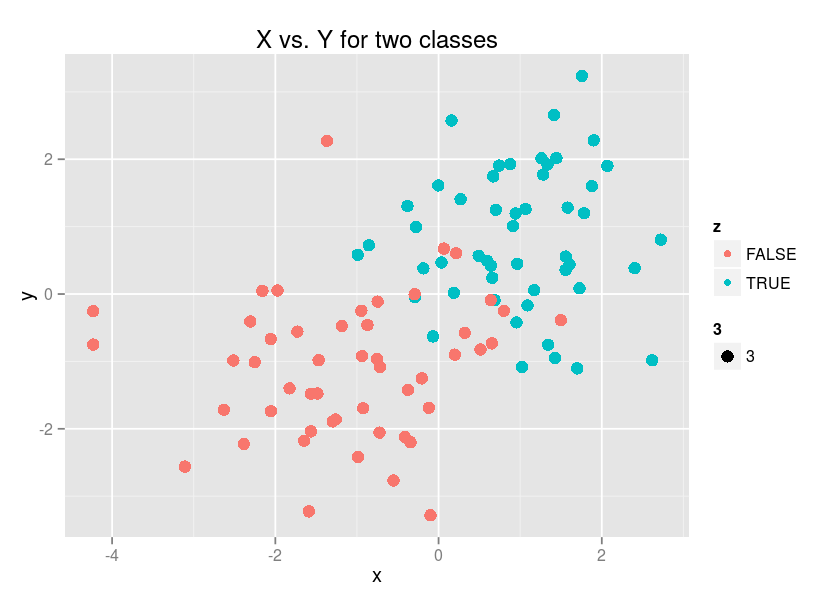

In [11]:
require(repr)
options(repr.plot.width=7, repr.plot.height=5)
plot.class = function(df){
  require(ggplot2)
  df$z = as.factor(df$z)
  ggplot(df, aes(x, y)) + 
    geom_point(aes(color = z, size = 3)) +
    ggtitle('X vs. Y for two classes')
}
plot.class(sim.data)

## Plot the logistic function

Logistic regression computes a binary {0,1} score using a logistic function. A value of the logistic function above the cutoff (typically 0.5) are scored as a 1 or true, and values less than the cutoff are scored as a 0 or false. Execute the code and examine the resulting logistic function.

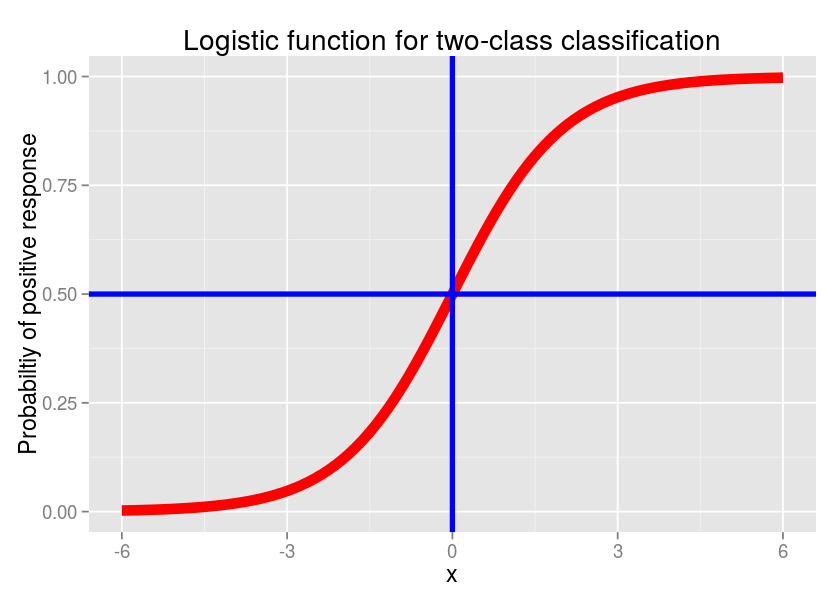

In [12]:
plot.logistic = function(upper = 6, lower = -6){
  require(ggplot2)
  x = seq(lower, upper, length = 100)
  y = exp(x)/(1 + exp(x))
  df = data.frame(x = x, y = y)
  ggplot(df, aes(x,y)) + geom_line(color = 'red', size = 3) +
    geom_vline(xintercept = 0, color = 'blue', size = 1.5) +
    geom_hline(yintercept = 0.5, color = 'blue', size = 1.5)+
    ggtitle('Logistic function for two-class classification') +
    ylab('Probabiltiy of positive response') +
    theme_grey(base_size = 14)
}
plot.logistic()

## Compute and score a logistic regression model

There is a considerable anount of code in the cell below. 

The fist function uses computes and scores a logsitic regression model.

The second function computes the evaluation of the logistic regression model in the following steps:
- Plot the correctly and incorrectly scored cases, using color and shape to identify class and classification correctness.
- Compute the elements of theh confusion matrix.
- Commonly used performance statistics are computed.

Execute this code and examine the results. Notice that most of the cases have been correctly classified. Classification errors appear along a boundary between those two classes. 

[1] "accuracy = 0.9"
[1] "precision = 0.884615"
[1] "recall = 0.92"
        Positive Negative
TruePos       46        4
TrueNeg        6       44


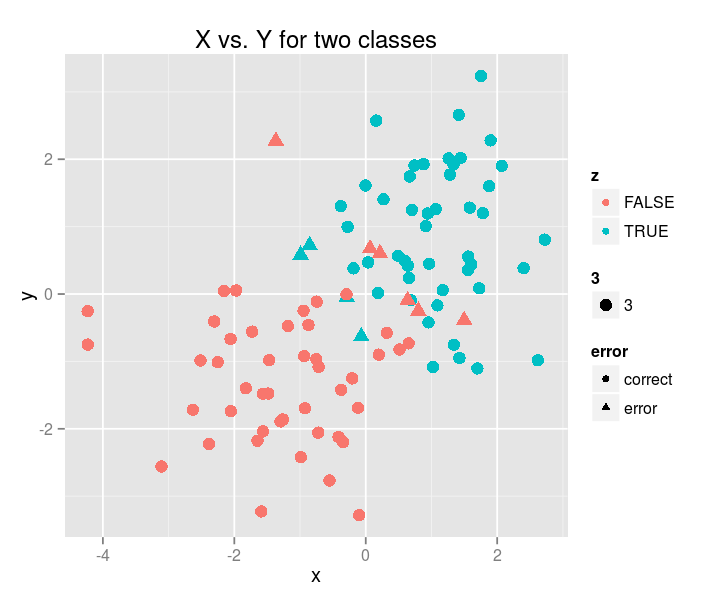

In [13]:
options(repr.plot.width=6, repr.plot.height=5)

logistic.mod <- function(df){
  glm(z ~ 0 + x + y, data = df, family = binomial)
}


logistic.pred = function(mod, df, prob = 0.5){
  df$score = ifelse(predict(mod, type = 'response') > prob, TRUE, FALSE)
  df
}

logistic.eval <- function(mod, df, prob = 0.5){
  require(ggplot2)
  df = logistic.pred(mod, df, prob = prob)
  df$conf = ifelse(df$z == TRUE & df$score == TRUE, 'TP',
                    ifelse(df$z == FALSE & df$score == TRUE, 'FP',
                           ifelse(df$z == FALSE & df$score == FALSE, 'TN', 'FN')))
  
  df$error = ifelse((df$conf == 'FP' | df$conf == 'FN'), 'error', 'correct')

  cols = c('z', 'error')
  df[, cols] = lapply(df[, cols], as.factor)

  p1 = ggplot(df, aes(x, y)) + 
    geom_point(aes(color = z, size = 3, shape = error)) +
    ggtitle('X vs. Y for two classes')
  print(p1)
  
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
  
  print(paste('accuracy =', as.character((TP + TN)/(TP + TN + FP + FN))))      
  print(paste('precision =', as.character(signif(TP/(TP + FP)), digits = 2)))     
  print(paste('recall =', as.character(TP/(TP + FN))))
  
  out = data.frame(Positive = c(TP, FP), Negative = c(FN, TN))
  row.names(out) = c('TruePos', 'TrueNeg')
  print(out)
}

mod = logistic.mod(sim.data)
logistic.eval(mod, sim.data)

## Moving the decision boundary

The example above uses a cutoff at the midpoint of the logistic function. However, you can change the trade-off between correctly classifying the positive cases and correctly classifing the negative cases. The code in the cell below computes and scores a logistic regressiion model for three different cutoff points. 

Run the code in the cell and carefully compare the results for the three cases. Notice, that as the logistic cutoff changes the decision boundary moves on the plot, with progressively more positive cases are correctly classified. In addition, accuracy and precision decrease and recall increases. 

[1] "accuracy = 0.74"
[1] "precision = 0.75"
[1] "recall = 0.72"
        Positive Negative
TruePos       36       14
TrueNeg       12       38


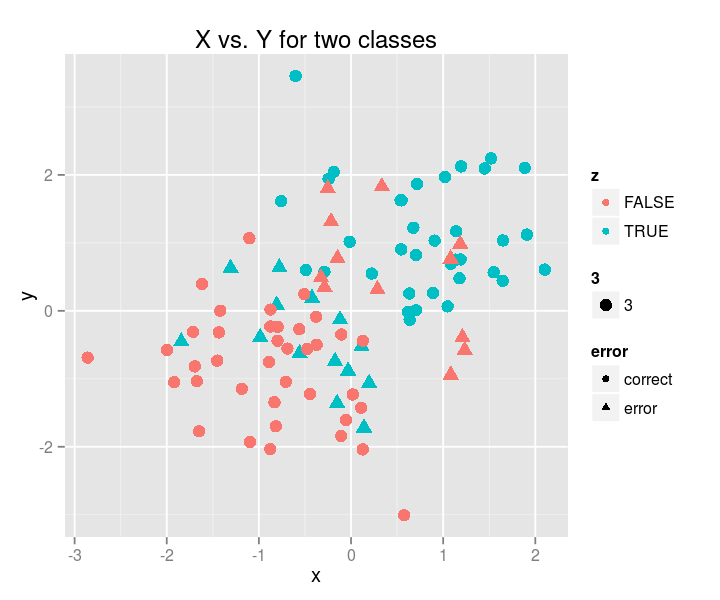

[1] "accuracy = 0.7"
[1] "precision = 0.638889"
[1] "recall = 0.92"
        Positive Negative
TruePos       46        4
TrueNeg       26       24


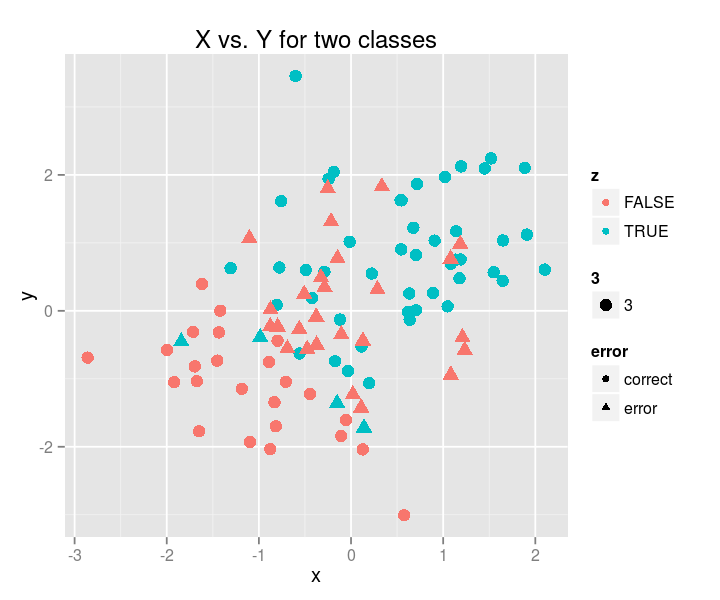

[1] "accuracy = 0.6"
[1] "precision = 0.556818"
[1] "recall = 0.98"
        Positive Negative
TruePos       49        1
TrueNeg       39       11


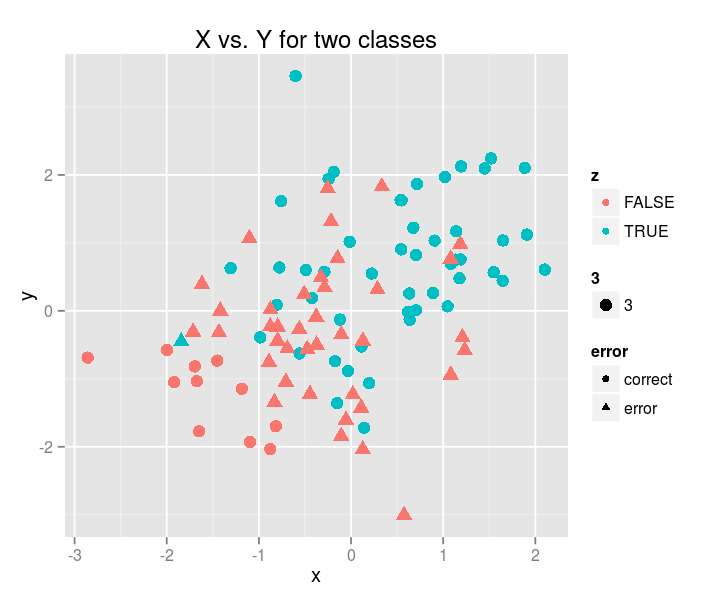

In [16]:
run.demo.prob <- function(){
  logt <- sim.logt.data(0.5, 0.5, 50, 1, -0.5, -0.5, 50, 1)
  probs = c(0.5, 0.25, 0.125)
  for(p in probs){    
    logMod <- logistic.mod(logt)
    logistic.eval(logMod, logt, p)
  }
}
run.demo.prob()